TV-Regularized Abel Inversion
=============================

This example demonstrates a TV-regularized Abel inversion by solving the
problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + \lambda \| C \mathbf{x} \|_1 \;,$$

where $A$ is the Abel projector (with an implementation based on a
projector from PyAbel <cite data-cite="pyabel-2022"/>), $\mathbf{y}$ is the measured
data, $C$ is a 2D finite difference operator, and $\mathbf{x}$ is the
desired image.

In [1]:
import numpy as np

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.examples import create_circular_phantom
from scico.linop.abel import AbelProjector
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # phantom size
x_gt = create_circular_phantom((N, N), [0.4 * N, 0.2 * N, 0.1 * N], [1, 0, 0.5])

Set up the forward operator and create a test measurement.

In [3]:
A = AbelProjector(x_gt.shape)
y = A @ x_gt
np.random.seed(12345)
y = y + np.random.normal(size=y.shape).astype(np.float32)
ATy = A.T @ y

Set up ADMM solver object.

In [4]:
λ = 2.9e1  # L1 norm regularization parameter
ρ = 8.5e1  # ADMM penalty parameter
maxiter = 100  # number of ADMM iterations
cg_tol = 1e-4  # CG relative tolerance
cg_maxiter = 25  # maximum CG iterations per ADMM iteration

# Note the use of anisotropic TV. Isotropic TV would require use of L21Norm.
g = λ * functional.L1Norm()
C = linop.FiniteDifference(input_shape=x_gt.shape)

f = loss.SquaredL2Loss(y=y, A=A)

x_inv = A.inverse(y)
x0 = snp.clip(x_inv, 0, 1.0)

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=x0,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": cg_tol, "maxiter": cg_maxiter}),
    itstat_options={"display": True, "period": 5},
)

Run the solver.

In [5]:
print(f"Solving on {device_info()}\n")
solver.solve()
hist = solver.itstat_object.history(transpose=True)
x_tv = snp.clip(solver.x, 0, 1.0)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  2.89e+00  5.035e+04  4.044e+01  8.611e+01     18  9.803e-05
   5  3.94e+00  6.350e+04  2.732e+00  3.015e+00      6  9.757e-05
  10  4.00e+00  6.561e+04  1.723e+00  1.363e-01      0  9.897e-05


  15  4.05e+00  6.740e+04  1.169e+00  4.013e-01      3  9.956e-05
  20  4.10e+00  6.763e+04  1.029e+00  7.913e-02      0  9.720e-05
  25  4.17e+00  6.851e+04  8.084e-01  2.630e-01      3  7.163e-05
  30  4.21e+00  6.839e+04  7.386e-01  5.401e-02      0  8.692e-05


  35  4.26e+00  6.873e+04  6.055e-01  4.908e-02      0  7.284e-05
  40  4.31e+00  6.898e+04  6.962e-01  4.542e-02      0  9.874e-05
  45  4.36e+00  6.919e+04  1.086e+00  3.191e-01      4  9.644e-05
  50  4.42e+00  6.942e+04  4.788e-01  2.542e-02      0  7.647e-05


  55  4.47e+00  6.934e+04  4.698e-01  2.675e-02      0  9.881e-05
  60  4.51e+00  6.939e+04  4.729e-01  2.478e-02      0  6.659e-05
  65  4.57e+00  6.951e+04  5.301e-01  2.421e-01      3  8.748e-05
  70  4.61e+00  6.961e+04  4.914e-01  3.722e-02      0  6.600e-05


  75  4.65e+00  6.999e+04  1.209e+00  6.268e-01      3  8.152e-05
  80  4.70e+00  6.987e+04  5.108e-01  7.025e-02      0  8.275e-05
  85  4.74e+00  6.973e+04  3.971e-01  5.058e-02      0  9.983e-05
  90  4.78e+00  6.977e+04  3.661e-01  2.633e-02      0  9.219e-05
  95  4.83e+00  6.985e+04  4.294e-01  4.382e-02      0  7.176e-05


  99  4.86e+00  7.002e+04  1.025e+00  5.212e-01      3  8.213e-05


Show results.

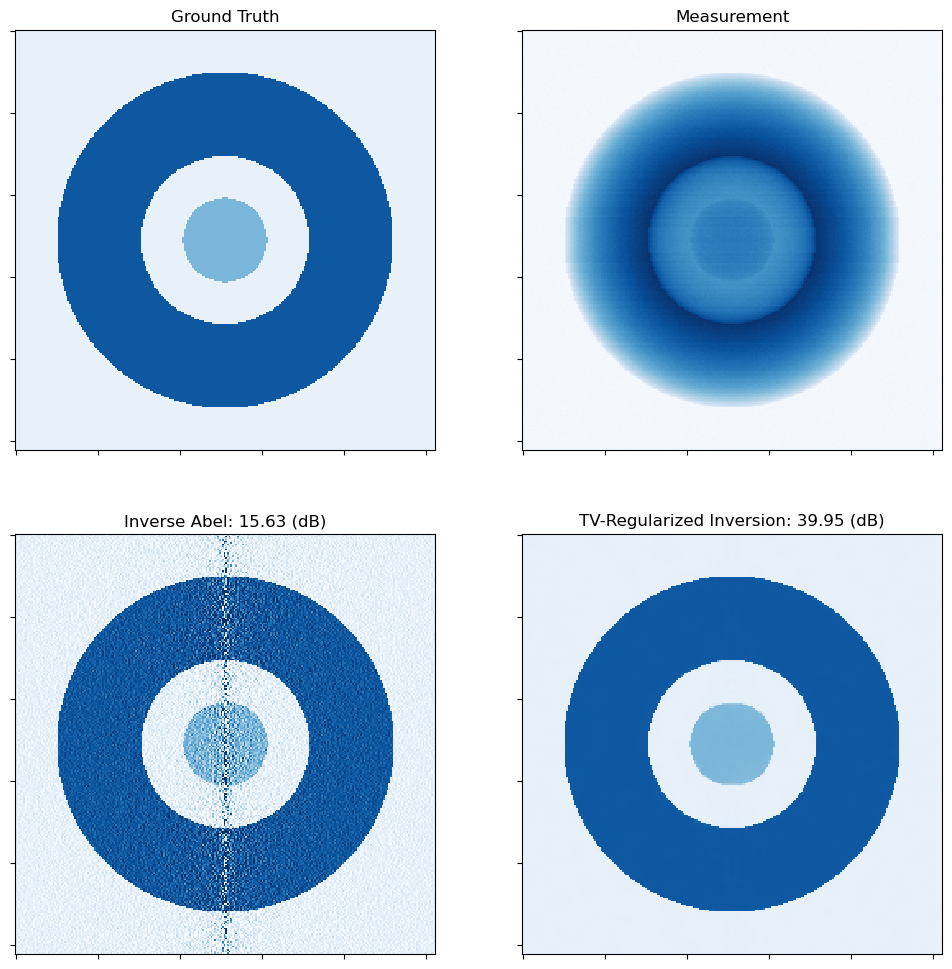

In [6]:
norm = plot.matplotlib.colors.Normalize(vmin=-0.1, vmax=1.2)
fig, ax = plot.subplots(nrows=2, ncols=2, figsize=(12, 12))
plot.imview(x_gt, title="Ground Truth", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 0], norm=norm)
plot.imview(y, title="Measurement", cmap=plot.cm.Blues, fig=fig, ax=ax[0, 1])
plot.imview(
    x_inv,
    title="Inverse Abel: %.2f (dB)" % metric.psnr(x_gt, x_inv),
    cmap=plot.cm.Blues,
    fig=fig,
    ax=ax[1, 0],
    norm=norm,
)
plot.imview(
    x_tv,
    title="TV-Regularized Inversion: %.2f (dB)" % metric.psnr(x_gt, x_tv),
    cmap=plot.cm.Blues,
    fig=fig,
    ax=ax[1, 1],
    norm=norm,
)
fig.show()